# FRANKE FUNCTION TASK 

***Part a)***

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import t


In [2]:
x = np.random.random(15)
y = np.random.random(15)

In [3]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [4]:
data = [[i, j, FrankeFunction(i, j)] for i in x for j in y]

In [5]:
data = np.array(data)

In [6]:
data[:,2] += np.random.random(size=data[:,2].shape)

In [7]:
X, y = np.hsplit(data, [2])

In [8]:
def PolyTransformer(X, degree=5):
    transformedX = list()
    for x,y in X:
        transformedSample = list()
        for p in range(1, degree+1):
            for n in range(p+1):
                transformedSample.append(x**(p-n) * y**n)
        transformedX.append(transformedSample)
    return np.array(transformedX)

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=.8)

In [10]:
train_X = PolyTransformer(train_X)

In [11]:
scaler = StandardScaler()

In [12]:
train_X = scaler.fit_transform(train_X)

In [13]:
beta = train_X.T @ train_X # beta will evolve according to the algorithm

In [14]:
U,S,V = np.linalg.svd(beta, hermitian=True)

# SVD is successful

In [15]:
np.allclose(U @ np.diag(S) @ V, beta)

True

In [16]:
invBeta = V.T @ np.diag(1/S) @ U.T

# Inversion is successful

In [17]:
np.allclose(invBeta, np.linalg.inv(beta))

True

In [18]:
beta = invBeta

In [19]:
beta = beta @ train_X.T

In [20]:
beta = beta @ train_y

In [21]:
def ols(X,y):
    beta = X.T @ X
    U,S,V = np.linalg.svd(beta, hermitian=True)
    beta = V.T @ np.diag(1/S) @ U.T
    beta = beta @ X.T
    return beta

In [22]:
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()

In [23]:
def r_2(y_true, y_pred):
    return 1 - ((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum()

In [24]:
mse(train_X @ beta, train_y)

0.8227561779189415

In [25]:
r_2(train_X @ beta, train_y)

-11.139126628118408

In [26]:
mse(test_y, scaler.transform(PolyTransformer(test_X)) @ beta)

1.023748150637539

In [27]:
r_2(test_y, scaler.transform(PolyTransformer(test_X)) @ beta)

-7.209847661626512

## Find confidence interval of beta parameter

In [28]:
#define var of beta
var_beta = np.diag(np.linalg.inv(train_X.T @ train_X))

In [29]:
#define std of beta
std_beta = np.sqrt(var_beta)

In [30]:
#define standard error of beta
se_beta = std_beta / np.sqrt(len(train_X))

In [31]:
t_value = t.ppf(1-0.025, train_X.shape[0]-train_X.shape[1])

In [32]:
#lower and upper confidence interval
CI=np.array([beta-t_value*se_beta, beta+t_value*se_beta])

lower = beta - t_value * se_beta
upper = beta + t_value * se_beta


In [33]:
def ci(train_X):
    #define var of beta
    var_beta = np.diag(np.linalg.inv(train_X.T @ train_X))
    #define std of beta
    std_beta = np.sqrt(var_beta)
    #define standard error of beta
    se_beta = std_beta / np.sqrt(len(train_X))
    t_value = t.ppf(1-0.025, train_X.shape[0]-train_X.shape[1])
    #lower and upper confidence interval
    CI=np.array([beta-t_value*se_beta, beta+t_value*se_beta])
    lower = beta - t_value * se_beta
    upper = beta + t_value * se_beta
    return (lower, upper)

# BIAS VARIANCE TRADEOFF 

***Part b***

In [34]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=.8)

from sklearn.utils import resample
k = 100 # bootstrap
complexity = 25

complexity_deg = np.zeros(complexity)
test_bias_square = np.zeros(complexity)
test_error = np.zeros(complexity)
test_variance = np.zeros(complexity)

train_bias_square = np.zeros(complexity)
train_error = np.zeros(complexity)
train_variance = np.zeros(complexity)


for ii in range(1, complexity):
    complexity_deg[ii] = ii
    resampled_X , resampled_y = resample(train_X, train_y)
    resampled_X = PolyTransformer(resampled_X, degree=ii)
    resampled_X = scaler.fit_transform(resampled_X)
    beta = resampled_X.T @ resampled_X
    U,S,V = np.linalg.svd(beta, hermitian=True)
    invBeta = V.T @ np.diag(1/S) @ U.T
    beta = invBeta
    beta = beta @ resampled_X.T
    beta = beta @ resampled_y
    pred_y = np.zeros((test_y.shape[0],k))
    test_X0 = test_X
    test_X0 = PolyTransformer(test_X, degree=ii)
    test_X0 = scaler.fit_transform(test_X0)
    
    for jj in range(k):
        pred_value = test_X0 @ beta 
        pred_y[:, jj] = pred_value.ravel()
        test_error[ii] = mse(test_y, pred_y).mean()
        #bias_square[ii] = mse(pred_y, np.mean(pred_y,axis=1,keepdims=True))
        #variance[ii] = np.var(pred_y,axis=1,keepdims=True).mean()
        train_error[ii] = mse(train_y, scaler.fit_transform(PolyTransformer(train_X, degree=ii)) @ beta)

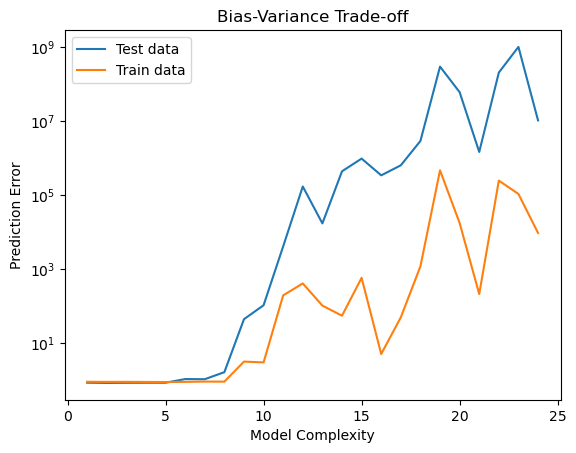

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(complexity_deg[1:], test_error[1:], label='Test data')
ax.plot(complexity_deg[1:], train_error[1:], label='Train data')
plt.legend()
ax.set_xlabel("Model Complexity")
ax.set_ylabel("Prediction Error")
ax.set_title("Bias-Variance Trade-off")
ax.set_yscale('log')

# Theory behind bias variance tradeoff


The bias-variance trade-off refers to the fact that decreasing the bias of a model will increase its variance, and vice versa. The goal in machine learning is to find a model that strikes a balance between bias and variance to achieve low total error. This balance can be achieved by selecting the appropriate model complexity, using regularization techniques, or by collecting more data.

Understanding bias - variance trade-off is critical for understanding the behavior of prediction models. We will highlight that we care about overall error, not the specific decomposition. The important characteristic for any model is the level of complexity at which the increase in bias is equivalent to the reduction in variance. Mathematically:

$$
\frac{\mathrm{d(Bias)}}{\mathrm{d (Complexity)}} = \frac{\mathrm{d (Variance)}}{d (Complexity)}
$$

**In our report, section number 3.1, derivation of expected test derror due to three main factors can be found. Anyway, we will show here final expression we have obtained.**


$$ \underbrace{E_{\mathbf{x}, y, D}\left[\left(h_{D}(\mathbf{x})-y\right)^{2}\right]}_{\text {Expected Test Error }}=\underbrace{E_{\mathbf{x}, D}\left[\left(h_{D}(\mathbf{x})-\bar{h}(\mathbf{x})\right)^{2}\right]}_{\text {Variance }}+\underbrace{E_{\mathbf{x}, y}\left[(\bar{y}(\mathbf{x})-y)^{2}\right]}_{\text {Noise }}+\underbrace{E_{\mathbf{x}}\left[(\bar{h}(\mathbf{x})-\bar{y}(\mathbf{x}))^{2}\right]}_{\text {Bias }^{2}} $$

This equation is analogue with equation provided in part b question of first project: 


$$ \underbrace{E \left[\left(\mathbf{y} -\tilde{\boldsymbol{y}}\right)^{2}\right]}_{\text {Expected Test Error }} =

\underbrace{ \frac{1}{n} \sum_i( f_i - E \left[\tilde{y}\right] )^2 }_{\text {Variance }}
+
\underbrace{\frac{1}{n} \sum_i \left( \tilde{y_i} - E \left[ \tilde{y}\right]\right)^2}_{\text {Bias}^{2}} + 

\underbrace{\sigma^2}_{\text {Noise}}


**As highlighted, epected error is sum of variance, bias and noise, meaning of these parameters will be explained as part of this file**

Namely, 

**Variance** refers to the random error or the spread of the model's predictions for different training sets. A high variance model is overly complex and fits the training data too closely, leading to high variance and poor generalization to new data. Variance is a measure of the variability of the model's predictions for different training sets. A high variance model is said to be too flexible and has a tendency to fit the noise in the data.

**Bias** refers to the systematic error or the deviation of the model's predictions from the true values. A high bias model is oversimplified and has a strong assumption about the relationship between the inputs and outputs. It is likely to underfit the data, leading to high training error and poor generalization to new data. Bias is a measure of how far the average prediction of the model is from the true values. A high bias model is said to be too rigid and has a tendency to ignore the underlying complexity of the data.

**Noise** refers to the random error or the inherent noise in the target variable. Noise is a measure of the inherent variability in the target variable. This term is an irreducible error. Given the true model and infinite data to calibrate it, we should be able to reduce both the bias and variance terms to 0. However, in a world with imperfect models and finite data, there is a tradeoff between minimizing the bias and minimizing the variance.




# Part c

In [36]:
def cv(model, X, y, fold = 10):
    foldSize = int(X.shape[0] / fold)
    Xs = np.vsplit(X, [foldSize * i for i in range(1, fold)])
    ys = np.vsplit(y, [foldSize * i for i in range(1, fold)])
    scores = list()
    for i in range(fold):
        validationSet_X = Xs[i:i+1]
        trainSet_X = np.concatenate([*Xs[0:i], *Xs[i+1:]], axis=0)
        validationSet_y = y[i:i+1]
        trainSet_y = np.concatenate([*y[0:i], *y[i+1:]], axis=0)
        scaler = StandardScaler()
        beta = model(scaler.fit_transform(PolyTransformer(trainSet_X)), trainSet_y)
        score = r_2(scaler.transform(PolyTransformer(validationSet_X)) @ beta, validationSet_y)
        scores.append(score)
    return np.array(scores).mean()

# Part d

In [37]:
def ridge(X,y, l):
    beta = X.T @ X
    beta += np.eye(beta.shape) * l
    U,S,V = np.linalg.svd(beta, hermitian=True)
    beta = V.T @ np.diag(1/S) @ U.T
    beta = beta @ X.T
    return beta

# part g

## GD

In [38]:
def GD(gradient, X, y, tol=1e-4):
    iteration, learning_rate, descent, beta = 0, .1, 1000, *np.random.random([2, 20])
    while np.abs(descent) < tol:
        descent,  beta = learning_rate * gradient(X, y, beta), beta - descent
    return beta

## GD with momentum

In [39]:
def GD(gradient, X, y, momentum, tol=1e-4):
    iteration, learning_rate, descent, beta = 0, .1, 1000, *np.random.random([2, X.shape[1]])
    while np.abs(descent) < tol:
        descent,  beta = learning_rate * gradient(X, y, beta) + descent * momentum, beta - descent
    return beta

## SGD with mini batch

In [40]:
def GD(gradient,  X, y, momentum, batch_size, learning_rate=.1, epoch= 1000, tol=1e-4):
    iteration, descent, beta = 0, *np.random.random([2, X.shape[1]])
    batch_size = int(batch_size)
    if tol <= 0: raise ValueError("'tolerance' must be greater than zero")
    if not 0 < batch_size <= n_obs: 
        raise ValueError("'batch_size' must be greater than zero and less than or equal to the number of observations")
    while epoch < iter:
        for i in range(0, X.shape[0], batch_size):
            batch_X, batch_y = X[i:i + batchSize], y[i:i + batchSize]
            descent,  beta = learning_rate * gradient(batch_X, batch_y, beta) + descent * momentum, beta - descent
    else: raise RuntimeError("Failed to converge to a minimum")
    return beta

## SGD with adagrad

In [41]:
def GD(gradient,  X, y, batch_size, learning_rate=.1, epsilon=1e-8, epoch= 1000, tol=1e-4):
    iteration, descent, beta = 0, *np.random.random([2, X.shape[1]])
    batch_size = int(batch_size)
    if tol <= 0: raise ValueError("'tolerance' must be greater than zero")
    if not 0 < batch_size <= n_obs: 
        raise ValueError("'batch_size' must be greater than zero and less than or equal to the number of observations")
    while epoch < iter:
        for i in range(0, X.shape[0], batch_size):
            batch_X, batch_y = X[i:i + batchSize], y[i:i + batchSize]
            grad = gradient(batch_X, batch_y, beta)
            rate = learning_rate / np.sqrt((grad**2).sum() + eepsilon)
            descent,  beta = rate  * grad, beta - descent
            if np.abs(descent) < tol: break
    else: raise RuntimeError("Failed to converge to a minimum")
    return beta

## SGD with adam

In [42]:
def GD(gradient,  X, y, batch_size, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, epoch= 1000, tol=1e-4):
    iteration, descent, beta = 0, *np.random.random([2, X.shape[1]])
    X, y = np.split(np.random.shuffle(np.concatenate([X,y], axis=1)), [X.shape])
    batch_size = int(batch_size)
    if tol <= 0: raise ValueError("'tolerance' must be greater than zero")
    if not 0 < batch_size <= n_obs: 
        raise ValueError("'batch_size' must be greater than zero and less than or equal to the number of observations")
    m_t, v_t, t = 0, 0, 0
    while epoch < iter:
        for i in range(0, X.shape[0], batch_size):
            batch_X, batch_y = X[i:i + batchSize], y[i:i + batchSize]
            grad = gradient(batch_X, batch_y, beta)
            t = t + 1    
            m_t = beta1 * m_t + (1 - beta1) * grad
            v_t = beta1 * v_t + (1 - beta2) * grad**2    
            m_cap_t = m_t / (1 - beta1**t)
            v_cap_t = v_t / (1 - beta2**t)
            descent,  beta = (learning_rate * m_cap_t) / (np.sqrt(v_cap_t) + epsilon), beta - descent
            if np.abs(descent) < tol: break
    else: raise RuntimeError("Failed to converge to a minimum")
    return beta